In [1]:
from typing import List, Tuple
import argparse
from collections import deque

import numpy as np
import torch
import yaml
from epsilon_transformers.process.MixedStateTree import (MixedStateTree,
                                                         MixedStateTreeNode)
from epsilon_transformers.process.Process import (
    Process, _compute_emission_probabilities, _compute_next_distribution)
from epsilon_transformers.process.processes import Mess3
from tqdm import tqdm

from src.utils import get_cached_belief_filename, MODEL_PATH_005_085, MODEL_PATH_015_06
from src.generate_paths_and_beliefs import generate_mess3_beliefs, save_beliefs
from typing import Tuple, Set, List
from pathlib import Path
from transformer_lens import HookedTransformer
from src.experiment import run_activation_to_beliefs_regression, r_squared, load_model

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.12/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
# class EvolutionaryAlgorithm:
#     def __init__(param_ranges: List[Tuple[float, float]])

In [7]:
def get_beliefs(x: float, a: float):
    file_path = Path(get_cached_belief_filename(x, a))
    if file_path.exists():
        return torch.load(file_path)
    else:
        inputs, input_beliefs = generate_mess3_beliefs(x, a, sort_pairs=True)
        # save_beliefs(inputs, input_beliefs, x, a)
        return {
            "params": {"x": x, "a": a},
            "inputs": inputs,
            "input_beliefs": input_beliefs,
        }

def evaluate(model: HookedTransformer, inputs: torch.Tensor, input_beliefs: torch.Tensor):
    _, activations = model.run_with_cache(
            inputs, names_filter=lambda x: "resid_post" in x
        )
    acts = activations["blocks.3.hook_resid_post"].cpu().detach().numpy()
    regression, belief_predictions = run_activation_to_beliefs_regression(
        acts, input_beliefs
    )

    rsq = r_squared(input_beliefs, belief_predictions)

    return rsq

In [121]:
p = get_beliefs(0.01, 0.9)
device = torch.device("cuda:1")
model = load_model(MODEL_PATH_005_085 / "684806400.pt", MODEL_PATH_005_085 / "train_config.json", device)
evaluate(model, p["inputs"], p["input_beliefs"])

tensor(0.9542, dtype=torch.float64)

In [47]:
import random
import numpy as np

# Define parameters
population_size = 10
generations = 5
mutation_rate = 0.5
crossover_rate = 0.7
elitism = 2

# Define ranges for x and a
x_range = (0.001, 0.5)
a_range = (0, 1)

# Fitness function
def evaluate_fitness(chromosome):
    x, a = chromosome
    belief_dict = get_beliefs(x, a)
    fitness = evaluate(model, belief_dict["inputs"], belief_dict["input_beliefs"])

    score = -torch.log(1 - fitness)

    return score

# Initialize population
def initialize_population(size):
    population = []
    for _ in range(size):
        x = random.uniform(*x_range)
        a = random.uniform(*a_range)
        population.append([x, a])
    return population

# Selection (Tournament Selection)
def select_parents(population, fitness, k=3):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, fitness)), k)
        winner = max(tournament, key=lambda ind: ind[1])[0]
        selected.append(winner)
    return selected

# Crossover (Single-Point Crossover)
def crossover(parent1, parent2):
    if random.random() < crossover_rate:
        point = random.randint(1, 1)
        child1 = [parent1[0], parent2[1]]
        child2 = [parent2[0], parent1[1]]
        return child1, child2
    else:
        return parent1, parent2

# Mutation
def mutate(chromosome, mutation_rate, generation, max_generations):
    adjusted_mutation_rate = mutation_rate * (1 - (generation / max_generations))
    if random.random() < adjusted_mutation_rate:
        chromosome[0] = np.clip(chromosome[0] + np.random.normal(0, 0.05), *x_range)
    if random.random() < adjusted_mutation_rate:
        chromosome[1] = np.clip(chromosome[1] + np.random.normal(0, 0.1), *a_range)
    return chromosome

# Replacement (Elitism)
def replace_population(old_population, new_population, fitness, elitism_count):
    combined = list(zip(old_population, fitness)) + [(child, evaluate_fitness(child)) for child in new_population]
    combined.sort(key=lambda ind: ind[1], reverse=True)
    next_generation = [ind[0] for ind in combined[:elitism_count]]
    
    remaining = combined[elitism_count:]
    while len(next_generation) < population_size:
        candidate = remaining.pop(0)[0] if remaining else [random.uniform(*x_range), random.uniform(*a_range)]
        if not any(np.linalg.norm(np.array(candidate) - np.array(ind)) < 0.1 for ind in next_generation):
            next_generation.append(candidate)
    
    return next_generation

# Main evolutionary algorithm
def evolutionary_algorithm():
    all_generations = []
    population = initialize_population(population_size)
    for generation in range(generations):
        print(population)
        fitness = [evaluate_fitness(chromosome).item() for chromosome in population]
        
        parents = select_parents(population, fitness)
        offspring = []
        while len(offspring) < population_size:
            parent1, parent2 = random.sample(parents, 2)
            child1, child2 = crossover(parent1, parent2)
            offspring.extend([mutate(child1, mutation_rate, generation, generations), mutate(child2, mutation_rate, generation, generations)])
        
        all_generations.append((population, fitness))

        population = replace_population(population, offspring, fitness, elitism)
    
    return all_generations

# Run the algorithm and print the best solution
all_generations = evolutionary_algorithm()
#    best_solution = max(population, key=evaluate_fitness)
# print("Best solution:", best_solution)
# print("Best fitness:", evaluate_fitness(best_solution))


[[0.156025603252551, 0.3454485226583415], [0.20225942053321166, 0.37674883878597354], [0.4780575432264609, 0.6356897795321035], [0.16525168919536862, 0.8382619123293342], [0.4385711151054011, 0.8682378729017474], [0.07172261515633209, 0.16198630825817473], [0.4414872737929617, 0.9784732272309548], [0.14622688602064188, 0.1427556990488965], [0.10879318870654392, 0.8318591122599809], [0.2864543573872564, 0.36946349053349303]]
[[0.10879318870654392, 0.7545296939283862], [0.10879318870654392, 0.7545296939283862], [0.10879318870654392, 0.9026535820937317], [0.19162293387897505, 0.9784732272309548], [0.4414872737929617, 0.9784732272309548], [0.2864543573872564, 0.36946349053349303], [0.14120628037044874, 0.5296119289580805], [0.14622688602064188, 0.1427556990488965], [0.4385711151054011, 0.8682378729017474], [0.4780575432264609, 0.6356897795321035]]
[[0.06778643245796745, 1.0], [0.06778643245796745, 1.0], [0.10879318870654392, 0.9026535820937317], [0.19162293387897505, 0.9784732272309548], [

In [96]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_n_coordinates(data, n, real_param, max_param=None):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Different colors for each tuple
    plt.figure(figsize=(10, 6))
    noise_level = 0.005  # Adjust noise level as needed

    all_coords = []
    
    for idx, (coords, z_values) in enumerate(data):
        # Convert lists to numpy arrays for easy manipulation
        coords = np.array(coords)
        z_values = np.array(z_values)
        
        # Get the indices of the top 5 z-values
        top_5_indices = np.argsort(z_values)[-n:]
        
        # Get the corresponding coordinates
        top_5_coords = coords[top_5_indices]
        
        # Collect all top 5 coordinates
        all_coords.append(top_5_coords)
    
    # Flatten the list of coordinates
    all_coords = np.vstack(all_coords)
    
    # Add noise to duplicates within and between tuples
    unique_coords, counts = np.unique(all_coords, axis=0, return_counts=True)
    for coord, count in zip(unique_coords, counts):
        if count > 1:
            duplicates = np.where((all_coords == coord).all(axis=1))[0]
            noise = np.random.normal(0, noise_level, (count, 2))
            all_coords[duplicates] += noise

    # Plot the points
    start = 0
    for idx, (coords, z_values) in enumerate(data):
        num_points = len(np.argsort(z_values)[-n:])
        top_5_coords = all_coords[start:start + num_points]
        start += num_points
        
        plt.scatter(top_5_coords[:, 0], top_5_coords[:, 1], color=colors[idx % len(colors)], label=f'Generation {idx+1}')
    
    # Plot real_param if provided
    if real_param is not None:
        plt.scatter(real_param[0], real_param[1], color='black', marker='x', s=100, label='Real Param')

    # Plot max_param if provided
    if max_param is not None:
        plt.scatter(max_param[0], max_param[1], color='black', marker='o', s=100, label='Param with max R^2')

    plt.xlim(0, 0.55)
    plt.ylim(0, 1.1)
    plt.xlabel('x')
    plt.ylabel('alpha')
    plt.title(f'Top {n} coordinates in each generation by R^2 for Mess3({real_param[0]},{real_param(1)})')
    plt.legend()
    plt.grid(True)
    plt.show()


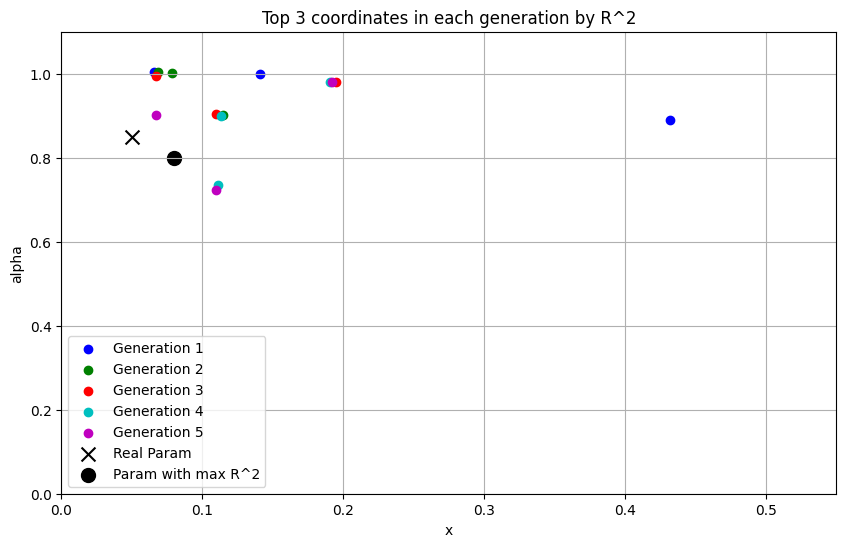

In [97]:
plot_top_n_coordinates(all_generations, 3, (0.05, 0.85), (0.08, 0.8))

In [98]:
import random
import numpy as np

# Define parameters
population_size = 10
generations = 5
mutation_rate = 0.5
crossover_rate = 0.7
elitism = 2
model_015_06 = load_model(MODEL_PATH_015_06 / "998406400.pt", MODEL_PATH_015_06 / "train_config.json", device)

# Define ranges for x and a
x_range = (0.001, 0.5)
a_range = (0, 1)

# Fitness function
def evaluate_fitness(chromosome):
    x, a = chromosome
    belief_dict = get_beliefs(x, a)
    fitness = evaluate(model_015_06, belief_dict["inputs"], belief_dict["input_beliefs"])

    score = -torch.log(1 - fitness)

    return score

# Initialize population
def initialize_population(size):
    population = []
    for _ in range(size):
        x = random.uniform(*x_range)
        a = random.uniform(*a_range)
        population.append([x, a])
    return population

# Selection (Tournament Selection)
def select_parents(population, fitness, k=3):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, fitness)), k)
        winner = max(tournament, key=lambda ind: ind[1])[0]
        selected.append(winner)
    return selected

# Crossover (Single-Point Crossover)
def crossover(parent1, parent2):
    if random.random() < crossover_rate:
        point = random.randint(1, 1)
        child1 = [parent1[0], parent2[1]]
        child2 = [parent2[0], parent1[1]]
        return child1, child2
    else:
        return parent1, parent2

# Mutation
def mutate(chromosome, mutation_rate, generation, max_generations):
    adjusted_mutation_rate = mutation_rate * (1 - (generation / max_generations))
    if random.random() < adjusted_mutation_rate:
        chromosome[0] = np.clip(chromosome[0] + np.random.normal(0, 0.05), *x_range)
    if random.random() < adjusted_mutation_rate:
        chromosome[1] = np.clip(chromosome[1] + np.random.normal(0, 0.1), *a_range)
    return chromosome

# Replacement (Elitism)
def replace_population(old_population, new_population, fitness, elitism_count):
    combined = list(zip(old_population, fitness)) + [(child, evaluate_fitness(child)) for child in new_population]
    combined.sort(key=lambda ind: ind[1], reverse=True)
    next_generation = [ind[0] for ind in combined[:elitism_count]]
    
    remaining = combined[elitism_count:]
    while len(next_generation) < population_size:
        candidate = remaining.pop(0)[0] if remaining else [random.uniform(*x_range), random.uniform(*a_range)]
        if not any(np.linalg.norm(np.array(candidate) - np.array(ind)) < 0.1 for ind in next_generation):
            next_generation.append(candidate)
    
    return next_generation

# Main evolutionary algorithm
def evolutionary_algorithm():
    all_generations = []
    population = initialize_population(population_size)
    for generation in range(generations):
        print(population)
        fitness = [evaluate_fitness(chromosome).item() for chromosome in population]
        
        parents = select_parents(population, fitness)
        offspring = []
        while len(offspring) < population_size:
            parent1, parent2 = random.sample(parents, 2)
            child1, child2 = crossover(parent1, parent2)
            offspring.extend([mutate(child1, mutation_rate, generation, generations), mutate(child2, mutation_rate, generation, generations)])
        
        all_generations.append((population, fitness))

        population = replace_population(population, offspring, fitness, elitism)
    
    return all_generations

# Run the algorithm and print the best solution
all_generations_015_06 = evolutionary_algorithm()
#    best_solution = max(population, key=evaluate_fitness)
# print("Best solution:", best_solution)
# print("Best fitness:", evaluate_fitness(best_solution))


[[0.2237053951880423, 0.3875567617762785], [0.40570498859119225, 0.8246237414125815], [0.0953124927265816, 0.549274669046123], [0.2521619182095867, 0.9840831451103498], [0.4719161175877988, 0.7484779911740637], [0.2465912624458304, 0.7699582133123081], [0.3877053056874437, 0.41069359497015534], [0.43712559366130166, 0.8419733623027538], [0.08812819730273326, 0.9471755536294861], [0.12068903187817678, 0.2523815859230655]]
[[0.16812079194791113, 0.3941566986351583], [0.1541138413548201, 0.3875567617762785], [0.08812819730273326, 0.9471755536294861], [0.12068903187817678, 0.5548716094982519], [0.2465912624458304, 0.7699582133123081], [0.19647390154596964, 0.9471755536294861], [0.12068903187817678, 0.2523815859230655], [0.40570498859119225, 0.8246237414125815], [0.3877053056874437, 0.41069359497015534], [0.2237053951880423, 0.03976337480257178]]
[[0.16812079194791113, 0.531017593169953], [0.19281621875178517, 0.5548716094982519], [0.16812079194791113, 0.3941566986351583], [0.12068903187817

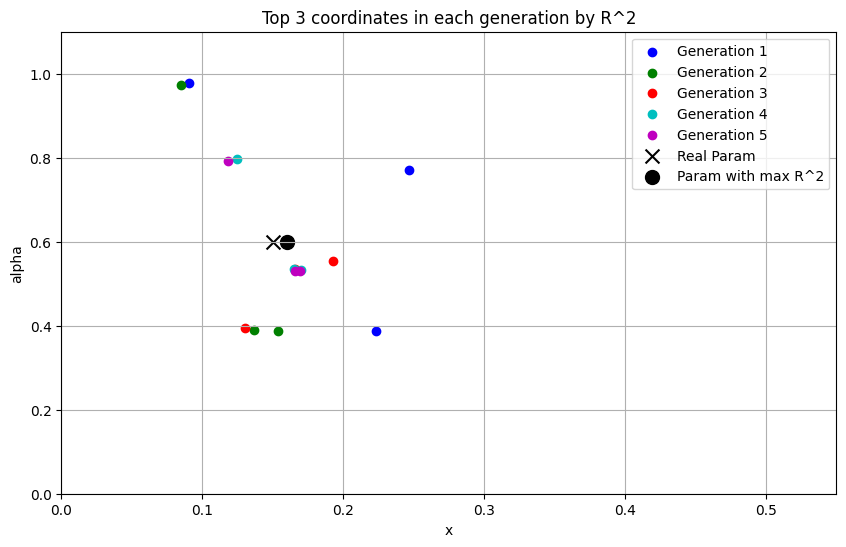

In [99]:
plot_top_n_coordinates(all_generations_015_06, 3, (0.15, 0.6), (0.16, 0.6))

In [116]:
import math
max_r2 = 0
max_point = []
max_gen = 0
for gen_idx, (points, fitnesses) in enumerate(all_generations):
    for i in range(len(points)):
        if 1 - math.exp(-fitnesses[i]) > max_r2:
            max_r2 = 1 - math.exp(-fitnesses[i])
            max_point = points[i]
            max_gen = gen_idx + 1
print(max_point, max_r2, max_gen)

[0.06688120922001017, 0.9026535820937317] 0.9975922561139456 5


In [126]:
points = [max_point, [0.15, 0.6], [0.16, 0.6]]

for x, a in points:
    belief_dict = get_beliefs(x, a)
    print(x, a, evaluate(model_015_06, belief_dict["inputs"], belief_dict["input_beliefs"]))

0.06688120922001017 0.9026535820937317 tensor(0.9940, dtype=torch.float64)
0.15 0.6 tensor(0.9992, dtype=torch.float64)
0.16 0.6 tensor(0.9992, dtype=torch.float64)


In [127]:
points = [max_point, [0.05, 0.85], [0.08, 0.8]]

for x, a in points:
    belief_dict = get_beliefs(x, a)
    print(x, a, evaluate(model, belief_dict["inputs"], belief_dict["input_beliefs"]))

0.06688120922001017 0.9026535820937317 tensor(0.9976, dtype=torch.float64)
0.05 0.85 tensor(0.9966, dtype=torch.float64)
0.08 0.8 tensor(0.9984, dtype=torch.float64)
